In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="darkgrid")
from datetime import datetime
import cvxpy as cp  
import scipy.optimize as sco
import numpy as np
#from arch import arch_model
#import empyrical as ep
from sklearn.covariance import LedoitWolf, MinCovDet
from pandas_datareader import data as wb
import time

In [ ]:
X=np.load("/content/drive/MyDrive/NIFTY 50 Dataset/Processed Data/X_1200.npy")
rb=np.load("/content/drive/MyDrive/NIFTY 50 Dataset/Processed Data/rb_1200.npy")

In [ ]:
X.shape

(1200, 49)

In [ ]:
rb.shape

(1200,)

In [ ]:
where_X_is_NaN=np.isnan(X)
where_rb_is_NaN=np.isnan(rb)

In [ ]:
#where_X_is_valid=np.logical_not(where_X_is_NaN)
#where_rb_is_valid=np.logical_not(where_rb_is_NaN)
X[where_X_is_NaN]=0
rb[where_rb_is_NaN]=0

T_test is the time period we want to hold the portfolio for.

In [ ]:
T=X.shape[0]
N=X.shape[1]
Aniket=0.5 #Aniket decides the proportion of Train data to Test Data

T_test= 240 #Decides the time we hold the portfolio for.
T_train=int(Aniket*T_test)

X_train=X[T_test:T_test+T_train,:]
X_test=X[:T_test,:]
X_train=np.flip(X_train)
X_test=np.flip(X_test)
rb_train=rb[T_test:T_test+T_train]
rb_test=rb[:T_test]
rb_train=np.flip(rb_train)
rb_test=np.flip(rb_test)

In [ ]:
# u = 0.5 #upper holding constraint
# l = 0.1 #lower holding constraint
# p = 1e-3  # parameters for the rho approximation of log
# lamb = 1e-6  # lambda is proportional to sparsity
# nu = 1e-3 # parameter that controls the penalization of weights that violate 
# N = 49
# # MM loop
# One=np.ones(N)
# nu_vector = One * nu
# l_vector= One * l
# u_vector = One* u
# w = np.ones(N)/N
# d0_u=1/(np.log(1+u/p)*(p+w))
# d0_l=1/(np.log(1+l/p)*(p+w))
# c0_l=1/(np.log(1+l/p))*(np.log(1+w/p)-(w/(p+w)))
# print(d0_l.shape)

# #new_term=np.multiply(d0_l,l_vector)



# #obj_value = np.array([1/T_train * np.linalg.norm(rb_train - X_train @ w)**2 + lamb * np.sum(np.log(1+np.abs(w)/p)/np.log(1+u/p)) + (nu_vector.T) @ np.maximum(np.diagflat(np.multiply(d0_l,l*One)-One) @ w + np.multiply(c0_l,(l*One)),0)])

In [ ]:
start= time.time()
u = 0.15 #upper holding constraint
l = 0.08 #lower holding constraint
p = 1e-3  # parameters for the rho approximation of log
lamb = 1e-5  # lambda is proportional to sparsity
nu = 1e-3 # parameter that controls the penalization of weights that violate 
N = 49
# MM loop
One=np.ones(N)
nu_vector = One * nu
w = np.ones(N)/N
d0_u=1/(np.log(1+u/p)*(p+w))
d0_l=1/(np.log(1+l/p)*(p+w))
c0_l=1/(np.log(1+l/p))*(np.log(1+w/p)-(w/(p+w)))




obj_value = np.array([1/T_train * np.linalg.norm(rb_train - X_train @ w)**2 + lamb * np.sum(np.log(1+np.abs(w)/p)/np.log(1+u/p)) + (nu_vector.T) @ np.maximum((np.diagflat(np.multiply(d0_l,l*One)-One) @ w + np.multiply(c0_l,(l*One))),0)])

while(True):
                  
    d_u = 1/(np.log(1+u/p)*(p+w))
    d_l=1/(np.log(1+l/p)*(p+w))
    c_l=(1/(np.log(1+l/p)))*(np.log(1+w/p)-(w/(p+w)))


    w_prev = w     
    
    w = cp.Variable(N,nonneg=True)
    obj = cp.Minimize(1/T_train * cp.sum_squares(rb_train - X_train @ w) + lamb * d_u @ w + (nu_vector.T) @ cp.maximum((cp.diag(cp.multiply(d0_l,l*One)-One) @ w + cp.multiply(c0_l,(l*One))),0))
                      
    prob = cp.Problem(obj, constraints = [w >= 0, cp.sum(w) == 1])
    result = prob.solve()   
    w = w.value
           
    obj_value = np.append(obj_value, 1/T_train * np.linalg.norm(rb_train - X_train @ w)**2 + lamb * np.sum(np.log(1+np.abs(w)/p)/np.log(1+u/p))+ (nu_vector.T) @ np.maximum((np.diagflat(np.multiply(d0_l,l*One)-One) @ w + np.multiply(c0_l,(l*One))),0))
  
    if(np.linalg.norm(w-w_prev)/np.linalg.norm(w_prev) < 1e-4):
        break

w_MM_single = w
end=time.time()


In [ ]:
N_Optimized=np.argwhere(w_MM_single>0.005).size
print(f"N_Optimized:{N_Optimized}")
print(w_MM_single)
running_time=end-start
print(f"Running Time:{running_time}")

N_Optimized:9
[0.00000000e+00 4.67053021e-22 0.00000000e+00 0.00000000e+00
 3.37735966e-22 0.00000000e+00 9.39151322e-02 1.83088897e-01
 5.18361723e-22 1.00187169e-21 4.93648893e-22 0.00000000e+00
 1.72165761e-22 6.48535368e-02 0.00000000e+00 0.00000000e+00
 4.19303908e-22 1.84339551e-22 1.12563604e-21 0.00000000e+00
 9.07926341e-02 4.96593138e-22 0.00000000e+00 4.98150464e-02
 6.86916981e-22 0.00000000e+00 0.00000000e+00 1.56580022e-01
 1.06545521e-21 0.00000000e+00 7.76633720e-02 2.03499282e-01
 0.00000000e+00 8.60670147e-23 5.94949887e-22 0.00000000e+00
 0.00000000e+00 7.97920780e-02 0.00000000e+00 6.81797198e-22
 0.00000000e+00 0.00000000e+00 1.03548043e-22 0.00000000e+00
 3.76517092e-22 0.00000000e+00 0.00000000e+00 7.64893822e-23
 6.14102369e-22]
Running Time:0.4713780879974365


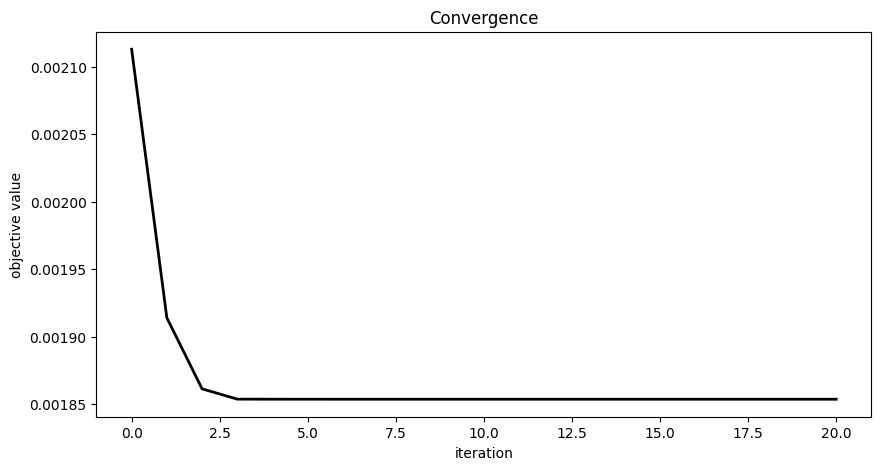

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(obj_value, lw=2, color='k')
plt.title('Convergence')
plt.xlabel('iteration')
plt.ylabel('objective value')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 3 Convergence for T={T_test}.jpg')

#Tracking Error

In [ ]:
train_error=(1/T_train)*np.linalg.norm(rb_train - X_train @ w_MM_single)**2
test_error=(1/T_test)*np.linalg.norm(rb_test - X_test @ w_MM_single)**2

In [ ]:
print(f"Train Error:{train_error}",train_error)
print(f"Test Error:{test_error}",test_error)

Train Error:3.7949472021670596e-05 3.7949472021670596e-05
Test Error:1.389238585478652e-05 1.389238585478652e-05


In [ ]:
returns_mm_train = X_train @ w_MM_single
returns_mm_test = X_test @ w_MM_single
rb_train=np.flip(rb_train)
rb_test=np.flip(rb_test)

In [ ]:
mm_PnL_train= np.array([1])
mm_PnL_test=np.array([1])
rb_PnL_train=np.array([1])
rb_PnL_test=np.array([1])
for i in returns_mm_train:
    mm_PnL_train = np.append(mm_PnL_train, mm_PnL_train[-1]*np.exp(i))
for i in returns_mm_test:
    mm_PnL_test = np.append(mm_PnL_test, mm_PnL_test[-1]*np.exp(i))
for i in rb_train:
    rb_PnL_train = np.append(rb_PnL_train, rb_PnL_train[-1]*np.exp(i))
for i in rb_test:
    rb_PnL_test = np.append(rb_PnL_test, rb_PnL_test[-1]*np.exp(i))


Plotting Tracked value vs Real value during training

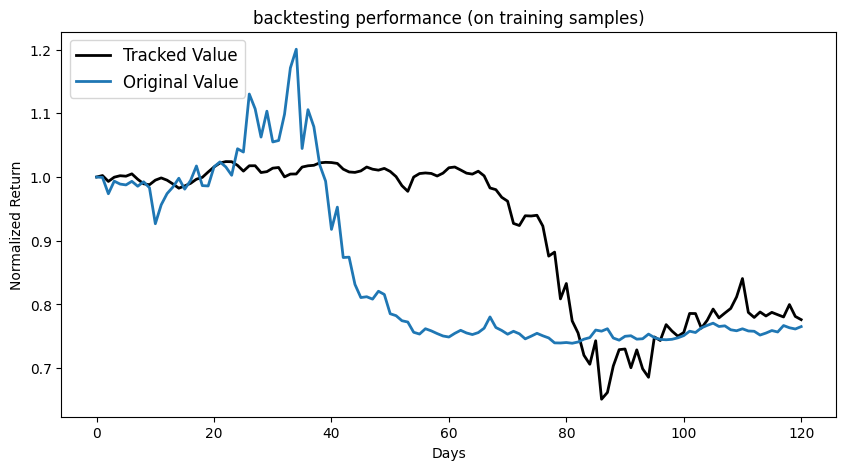

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(mm_PnL_train, label='Tracked Value', lw=2, color='k')
plt.plot(rb_PnL_train, label='Original Value', lw=2)

plt.legend(loc='upper left', fontsize=12)
plt.title('backtesting performance (on training samples)')
plt.xlabel('Days')
plt.ylabel('Normalized Return')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 3 Testing for T={T_test}.jpg')

Plotting Tracked value vs Real value during testing

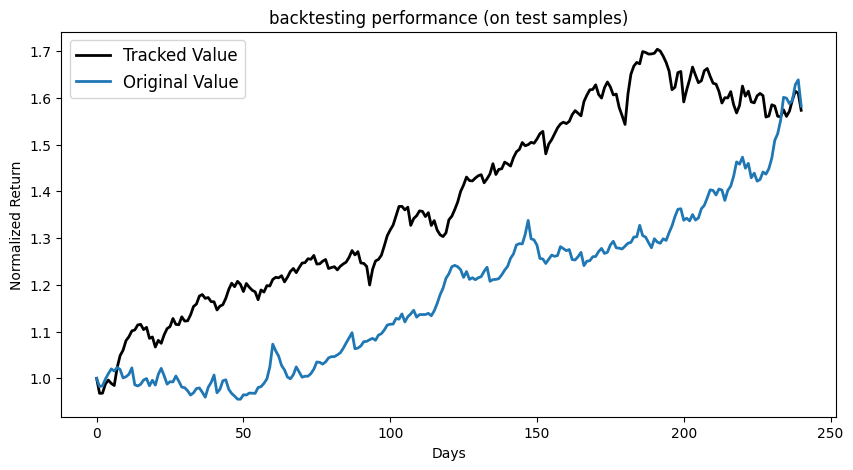

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(mm_PnL_test, label='Tracked Value', lw=2, color='k')
plt.plot(rb_PnL_test, label='Original Value', lw=2)

plt.legend(loc='upper left', fontsize=12)
plt.title('backtesting performance (on test samples)')
plt.xlabel('Days')
plt.ylabel('Normalized Return')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 3 Training for T={T_test}.jpg')